Постановка задачи:

1. Решить задачу линейного программирования на минимум и на максимум при помощи библиотек pulp, scipy.Optimize, cvxopt
2. Построить решение в графическом виде, указав оптимальные точки
3. Сверить ответ с приведенным ответом (как правило, приведен один вариант ответа), сверить ответы между собой — вывести таблицу в виде: метод — ответ — время

In [ ]:
!pip install pulp cvxopt

import pulp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import cvxopt
import cvxopt.solvers
import time


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 91.6 MB/s eta 0:00:00


In [ ]:
import pulp
import numpy as np
from scipy.optimize import linprog
import cvxopt
import cvxopt.solvers
import time
import matplotlib.pyplot as plt
import numpy as np

def solve_with_pulp():
    """Решение с использованием PuLP"""
    start_time = time.time()

    # Минимизация
    prob_min = pulp.LpProblem("Minimization", pulp.LpMinimize)
    x_min = pulp.LpVariable('x', lowBound=0)
    y_min = pulp.LpVariable('y', lowBound=0)

    prob_min += x_min - 2*y_min
    prob_min += 5*x_min + 3*y_min >= 30
    prob_min += x_min - y_min <= 3
    prob_min += -3*x_min + 5*y_min <= 15

    prob_min.solve(pulp.PULP_CBC_CMD(msg=0))
    min_value = pulp.value(prob_min.objective)
    min_x, min_y = x_min.varValue, y_min.varValue

    # Максимизация
    prob_max = pulp.LpProblem("Maximization", pulp.LpMaximize)
    x_max = pulp.LpVariable('x', lowBound=0)
    y_max = pulp.LpVariable('y', lowBound=0)

    prob_max += x_max - 2*y_max
    prob_max += 5*x_max + 3*y_max >= 30
    prob_max += x_max - y_max <= 3
    prob_max += -3*x_max + 5*y_max <= 15

    prob_max.solve(pulp.PULP_CBC_CMD(msg=0))
    max_value = pulp.value(prob_max.objective)
    max_x, max_y = x_max.varValue, y_max.varValue

    end_time = time.time()

    return {
        'method': 'PuLP',
        'min_value': min_value,
        'min_point': (min_x, min_y),
        'max_value': max_value,
        'max_point': (max_x, max_y),
        'time': end_time - start_time
    }

def solve_with_scipy():
    """Решение с использованием SciPy"""
    start_time = time.time()

    # Коэффициенты целевой функции (минимизация: x - 2y)
    c = [1, -2]

    # Ограничения в форме A_ub * x <= b_ub
    A_ub = [[-5, -3],  # 5x + 3y >= 30 -> -5x - 3y <= -30
            [1, -1],   # x - y <= 3
            [-3, 5]]   # -3x + 5y <= 15
    b_ub = [-30, 3, 15]

    # Границы переменных
    bounds = [(0, None), (0, None)]

    # Минимизация
    res_min = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds)
    min_value = res_min.fun
    min_x, min_y = res_min.x

    # Максимизация (меняем знак целевой функции)
    res_max = linprog([-1, 2], A_ub=A_ub, b_ub=b_ub, bounds=bounds)
    max_value = -res_max.fun
    max_x, max_y = res_max.x

    end_time = time.time()

    return {
        'method': 'SciPy',
        'min_value': min_value,
        'min_point': (min_x, min_y),
        'max_value': max_value,
        'max_point': (max_x, max_y),
        'time': end_time - start_time
    }

def solve_with_cvxopt():
    """Решение с использованием CVXOPT"""
    start_time = time.time()

    # Для минимизации: c^T * x
    # Целевая функция: x - 2y -> [1, -2]
    c = cvxopt.matrix([1.0, -2.0])

    # Ограничения: G*x <= h
    # 5x + 3y >= 30 -> -5x - 3y <= -30
    # x - y <= 3
    # -3x + 5y <= 15
    # x >= 0, y >= 0 -> -x <= 0, -y <= 0
    G = cvxopt.matrix([[-5.0, -3.0],   # 5x + 3y >= 30
                       [1.0, -1.0],    # x - y <= 3
                       [-3.0, 5.0],    # -3x + 5y <= 15
                       [-1.0, 0.0],    # x >= 0
                       [0.0, -1.0]])   # y >= 0

    h = cvxopt.matrix([-30.0, 3.0, 15.0, 0.0, 0.0])

    # Минимизация
    cvxopt.solvers.options['show_progress'] = False
    try:
        sol_min = cvxopt.solvers.lp(c, G, h)
        if sol_min['status'] == 'optimal':
            min_x, min_y = sol_min['x'][0], sol_min['x'][1]
            min_value = min_x - 2*min_y
        else:
            min_x, min_y, min_value = None, None, None
    except:
        min_x, min_y, min_value = None, None, None

    # Максимизация: меняем знак целевой функции
    c_max = cvxopt.matrix([-1.0, 2.0])
    try:
        sol_max = cvxopt.solvers.lp(c_max, G, h)
        if sol_max['status'] == 'optimal':
            max_x, max_y = sol_max['x'][0], sol_max['x'][1]
            max_value = max_x - 2*max_y
        else:
            max_x, max_y, max_value = None, None, None
    except:
        max_x, max_y, max_value = None, None, None

    end_time = time.time()

    return {
        'method': 'CVXOPT',
        'min_value': min_value if min_value is not None else 'Error',
        'min_point': (min_x, min_y) if min_x is not None else 'Error',
        'max_value': max_value if max_value is not None else 'Error',
        'max_point': (max_x, max_y) if max_x is not None else 'Error',
        'time': end_time - start_time
    }

# Запуск всех методов
results = []
results.append(solve_with_pulp())
results.append(solve_with_scipy())
results.append(solve_with_cvxopt())

# Вывод результатов
print("Сравнение методов:")
print("Метод\t\tMin значение\tMin точка\t\tMax значение\tMax точка\t\tВремя (с)")
print("-" * 100)
for res in results:
    min_val_str = f"{res['min_value']:.2f}" if isinstance(res['min_value'], (int, float)) else str(res['min_value'])
    max_val_str = f"{res['max_value']:.2f}" if isinstance(res['max_value'], (int, float)) else str(res['max_value'])
    min_pt_str = f"({res['min_point'][0]:.1f}, {res['min_point'][1]:.1f})" if res['min_point'] != 'Error' else 'Error'
    max_pt_str = f"({res['max_point'][0]:.1f}, {res['max_point'][1]:.1f})" if res['max_point'] != 'Error' else 'Error'

    print(f"{res['method']:8}\t{min_val_str:>8}\t{min_pt_str:15}\t{max_val_str:>8}\t{max_pt_str:15}\t{res['time']:.6f}")

# Проверка с приведенным ответом
given_min = 15 - 2*12  # F(15,12) = -9
print(f"\nПриведенный ответ: F_min = F(15,12) = {given_min}")

Сравнение методов:
Метод		Min значение	Min точка		Max значение	Max точка		Время (с)
----------------------------------------------------------------------------------------------------
PuLP    	   -9.00	(15.0, 12.0)   	    1.12	(4.9, 1.9)     	0.012367
SciPy   	   -9.00	(15.0, 12.0)   	    1.12	(4.9, 1.9)     	0.004059
CVXOPT  	   Error	Error          	   Error	Error          	0.000059

Приведенный ответ: F_min = F(15,12) = -9


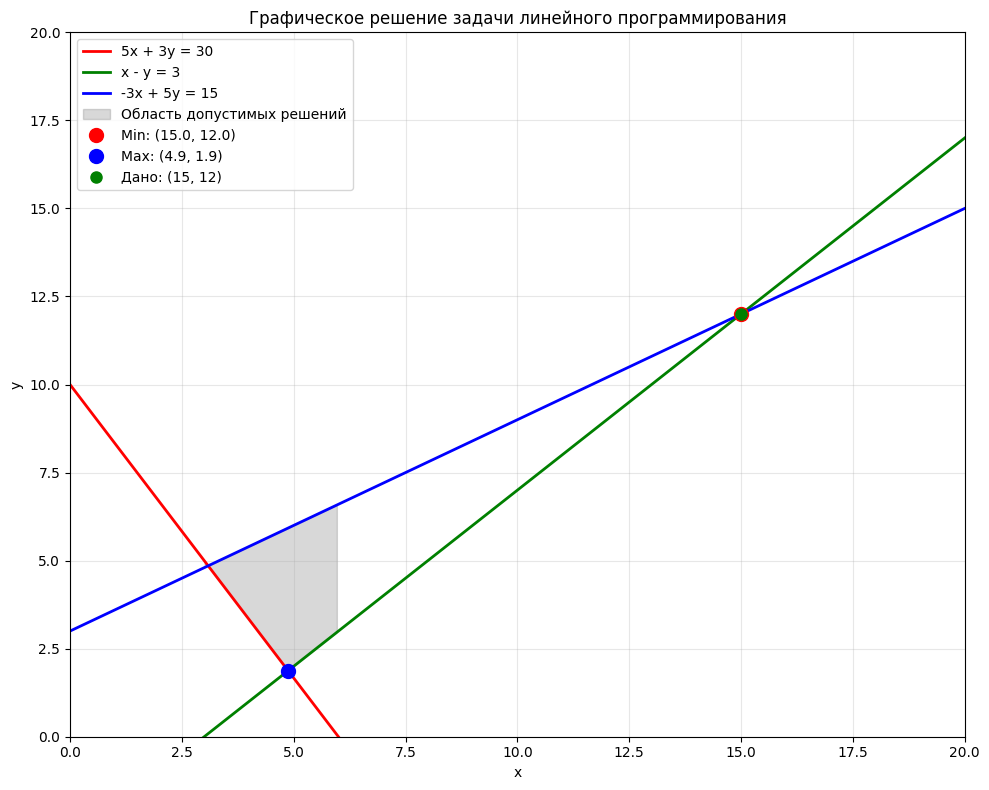


Оптимальные точки:
Минимум: F(15.00, 12.00) = -9.00
Максимум: F(4.88, 1.88) = 1.12


In [ ]:
def plot_solution():
    """Построение графического решения"""
    fig, ax = plt.subplots(figsize=(10, 8))

    # Создаем сетку точек
    x = np.linspace(0, 20, 400)
    y = np.linspace(0, 20, 400)
    X, Y = np.meshgrid(x, y)

    # Ограничения
    # 5x + 3y >= 30 -> y >= (30 - 5x)/3
    # x - y <= 3 -> y >= x - 3
    # -3x + 5y <= 15 -> y <= (15 + 3x)/5

    # Область допустимых решений
    feasible = (5*X + 3*Y >= 30) & (X - Y <= 3) & (-3*X + 5*Y <= 15) & (X >= 0) & (Y >= 0)

    # Целевая функция
    Z = X - 2*Y

    # Построение ограничений
    y1 = (30 - 5*x) / 3  # 5x + 3y = 30
    y2 = x - 3           # x - y = 3
    y3 = (15 + 3*x) / 5  # -3x + 5y = 15

    # Построение линий ограничений
    ax.plot(x, y1, 'r-', linewidth=2, label='5x + 3y = 30')
    ax.plot(x, y2, 'g-', linewidth=2, label='x - y = 3')
    ax.plot(x, y3, 'b-', linewidth=2, label='-3x + 5y = 15')

    # Заполнение области допустимых решений
    ax.fill_between(x, np.maximum(y1, y2), y3, where=(x>=0)&(y1>=0)&(y2>=0)&(y3>=0),
                   alpha=0.3, color='gray', label='Область допустимых решений')

    # Отметка оптимальных точек
    min_point = results[0]['min_point']  # Берем из любого метода
    max_point = results[0]['max_point']

    ax.plot(min_point[0], min_point[1], 'ro', markersize=10, label=f'Min: ({min_point[0]:.1f}, {min_point[1]:.1f})')
    ax.plot(max_point[0], max_point[1], 'bo', markersize=10, label=f'Max: ({max_point[0]:.1f}, {max_point[1]:.1f})')

    # Проверка точки из условия
    ax.plot(15, 12, 'go', markersize=8, label='Дано: (15, 12)')

    # Настройка графика
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Графическое решение задачи линейного программирования')
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()

    return min_point, max_point

# Построение графика
min_pt, max_pt = plot_solution()

print(f"\nОптимальные точки:")
print(f"Минимум: F({min_pt[0]:.2f}, {min_pt[1]:.2f}) = {min_pt[0] - 2*min_pt[1]:.2f}")
print(f"Максимум: F({max_pt[0]:.2f}, {max_pt[1]:.2f}) = {max_pt[0] - 2*max_pt[1]:.2f}")